In [937]:
import pandas as pd
import pdfplumber
import numpy as np
from utils import *

## Table detection

In [938]:
# pdf_restric

In [939]:
pdf_path = "mcs2024.pdf"

material = 'Sand and Gravel'

p = 159


pdf_restric = {material: [p, p+1]}

selected_p = p

scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

selected_content = 'content_1'

if selected_content == 'content_1':
    selected_p = p - 1
else:
    selected_p = p

selected_page = scraping_base[material][selected_content]
df = selected_page
page_text_df = selected_page


bounding_box = extract_cols(page_text_df, 'x1', 2)

In [940]:
# pdf_path = "mcs2024.pdf"

# material = 'ABRASIVES'

# p = 34


# pdf_restric = {material: [p, p+1]}

# selected_p = p

# scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

# selected_content = 'content_2'

# if selected_content == 'content_1':
#     selected_p = p - 1
# else:
#     selected_p = p

# selected_page = scraping_base[material][selected_content]
# df = selected_page
# page_text_df = selected_page


# bounding_box = extract_cols(page_text_df, 'x1', 2)

In [941]:
# Compute margin_top
df['margin_top'] = df['bottom'] - df['top'].shift(1) # refering to previous word (in reading order)

# Fill the last value of margin_top with 0 or NaN as it has no preceding word
df['margin_top'] = df['margin_top'].fillna(0)

# set margin_top to 0 words in same line
df['margin_top'] = df.apply(lambda row: 0 if row['top'] == df['top'].shift(1).loc[row.name] else row['margin_top'], axis=1)

gap_y_df = df[df['margin_top'] > 27]
# Perspective : change threshold using statistic (example : quantile 75 of margin_top)

In [942]:
# bounding_box['max_top_class'] = bounding_box['max_top'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['max_top_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['max_top_class'].isin(class_counts[class_counts > 1].index)]

In [943]:
# bounding_box['min_bottom_class'] = bounding_box['min_bottom'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['min_bottom_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['min_bottom_class'].isin(class_counts[class_counts > 1].index)]

In [944]:
bounding_box

,x1,min_bottom,max_top
0,297.71,422.1765,192.64752
1,297.72,444.1965,203.17650
2,351.71,422.1765,214.15650
3,351.72,444.1965,191.37648


In [945]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming bounding_box is already defined as a DataFrame

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

combined_data = np.concatenate((bounding_box[['min_bottom']], bounding_box[['max_top']]), axis=0)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the combined data
normalized_combined_data = scaler.fit_transform(combined_data)

# Split the combined data back into two columns
split_index = len(bounding_box)
normalized_min_bottom = normalized_combined_data[:split_index]
normalized_max_top = normalized_combined_data[split_index:]

# Assign the scaled values back to the DataFrame
bounding_box['min_bottom_normalized'] = np.round(normalized_min_bottom, 0)
bounding_box['max_top_normalized'] = np.round(normalized_max_top, 0)

In [946]:
bounding_box

,x1,min_bottom,max_top,min_bottom_normalized,max_top_normalized
0,297.71,422.1765,192.64752,1.0,0.0
1,297.72,444.1965,203.17650,1.0,0.0
2,351.71,422.1765,214.15650,1.0,0.0
3,351.72,444.1965,191.37648,1.0,0.0


In [947]:
# Group by 'min_bottom_normalized' and 'max_top_normalized'
grouped = bounding_box.groupby(['min_bottom_normalized'])

# Convert each group into a separate dataframe and store them in a list
list_of_dfs = [group.reset_index(drop=True) for _, group in grouped]

list_of_top_bottom_bbox = []
for _, group in grouped:
    if len(group) > 1:
        list_of_top_bottom_bbox.append({
            'bbox_top': float(group['max_top'].min()),
            'bbox_bottom': float(group['min_bottom'].max())
        })

In [948]:
list_of_top_bottom_bbox

[{'bbox_top': 191.37648000000002, 'bbox_bottom': 444.1965}]

In [949]:
list_of_bbox = []
list_of_table_df = []
for top_bottom_bbox in list_of_top_bottom_bbox:
    bbox_top, bbox_bottom = top_bottom_bbox['bbox_top'], top_bottom_bbox['bbox_bottom']

    # Find the nearest 'top' and 'bottom' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
    gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
    gap_y_df['total_diff'] = gap_y_df['top_diff'] + gap_y_df['bottom_diff']

    # Get the row with the minimum total difference
    nearest_row = gap_y_df.loc[gap_y_df['total_diff'].idxmin()]
    nearest_row['top']


    # Calculate the differences between bbox_top and the 'top' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)


    # Find the row with the minimum 'top_diff' and maximum 'bottom_diff'
    nearest_top_row = gap_y_df.loc[gap_y_df['top_diff'].idxmin()]


    # Filter the dataframe to only include rows with the nearest 'top' and 'bottom' values
    nearest_top_df = gap_y_df[gap_y_df['top'] == nearest_top_row['top']]
    bbox_top_final, bbox_bottom_final = nearest_top_df['top'], bbox_bottom
    
    padding = 5

    bbox_top_final, bbox_bottom_final = float(
        nearest_top_df['top']), float(bbox_bottom)

    table_df = page_text_df[(page_text_df['top'] >= bbox_top_final - padding)
                            & (page_text_df['bottom'] <= bbox_bottom_final + padding)]

    bbox_start, bbox_end = float(
        table_df['x0'].min()), float(table_df['x1'].max())

    list_of_bbox.append({
        'bbox_top': bbox_top_final,
        'bbox_bottom': bbox_bottom_final,
        'bbox_start': bbox_start,
        'bbox_end': bbox_end
    })
    list_of_table_df.append(table_df)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_90880\2341685080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_90880\2341685080.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_90880\2341685080.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [950]:
list_of_bbox

[{'bbox_top': 181.66751999999997,
  'bbox_bottom': 444.1965,
  'bbox_start': 44.94,
  'bbox_end': 526.3559879999999}]

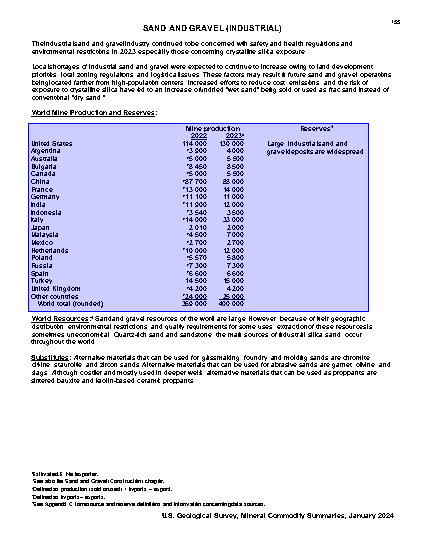

In [951]:
with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[selected_p].to_image(resolution=50)
    
# Draw a rectangle using the bounding box coordinates
border_color = "blue"

for bbox in list_of_bbox:
    # Draw a rectangle using the bounding box coordinates with specified colors
    im.draw_rect([bbox['bbox_start'] - padding, bbox['bbox_top'] - padding, bbox['bbox_end'] + padding, bbox['bbox_bottom'] + padding], 
                stroke=border_color, stroke_width=1)

im

In [952]:
# STOP HERE 

## Table to Dataframe

In [953]:
import re

# Remove special characters from 'text'
table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))

C:\Users\DataScience\AppData\Local\Temp\ipykernel_90880\1481100593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))


In [954]:
table_df

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
111,Mine,267.660000,290.453496,181.66752,122976.00108,191.68752,True,10.02000,22.793496,ltr,32.01900
112,production,293.222022,345.493356,181.66752,122976.00108,191.68752,True,10.02000,52.271334,ltr,0.00000
113,Reserves4,432.420000,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14000
114,2022,275.400000,297.714540,192.64752,122986.98108,202.66752,True,10.02000,22.314540,ltr,22.15104
115,2023e,325.800000,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02000
...,...,...,...,...,...,...,...,...,...,...,...
190,World,54.120000,80.271198,434.17650,123228.51006,444.19650,True,10.02000,26.151198,ltr,21.06000
191,total,83.041728,101.947464,434.17650,123228.51006,444.19650,True,10.02000,18.905736,ltr,0.00000
192,rounded,104.702964,148.125636,434.17650,123228.51006,444.19650,True,10.02000,43.422672,ltr,0.00000
193,359000,261.540000,297.716208,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000


In [955]:
# filter indices (smaller than most used text height)

mode_height = table_df['height'].mode()[0]

table_df = table_df[table_df['height'] > round(mode_height, 0)] 

In [956]:
table_df[table_df['height'] > mode_height]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
113,Reserves4,432.42,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14
115,2023e,325.80,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02
125,e3900,269.04,297.714048,213.06600,123007.39956,224.17650,True,11.11050,28.674048,ltr,10.02
132,e5000,269.04,297.714048,224.04600,123018.37956,235.15650,True,11.11050,28.674048,ltr,10.02
135,e8450,269.04,297.714048,235.08600,123029.41956,246.19650,True,11.11050,28.674048,ltr,10.02
138,e5000,269.04,297.714048,246.06600,123040.39956,257.17650,True,11.11050,28.674048,ltr,10.02
141,e87700,263.46,297.715188,257.04600,123051.37956,268.15650,True,11.11050,34.255188,ltr,10.02
144,e13000,263.46,297.715188,268.08600,123062.41956,279.19650,True,11.11050,34.255188,ltr,10.02
147,e11100,263.46,297.715188,279.06600,123073.39956,290.17650,True,11.11050,34.255188,ltr,10.02
150,e11900,263.46,297.715188,290.04600,123084.37956,301.15650,True,11.11050,34.255188,ltr,10.02


In [957]:
# # Filter rows where 'height' is greater than mode_height to delete indice from string
# filtered_df = table_df[table_df['height'] > mode_height]

# # Function to remove the last string from a given string
# def remove_last_string(s):  # remove non digit char🔴
#     s = s.strip()
#     return s[:-1]

# # Apply the function to the 'row' column of the filtered DataFrame
# filtered_df['text'] = filtered_df['text'].apply(remove_last_string)

# # Update the original DataFrame with the modified values
# table_df.loc[table_df['height'] > mode_height, 'text'] = filtered_df['text']

In [958]:
table_df[table_df['height'] > mode_height]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
113,Reserves4,432.42,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14
115,2023e,325.80,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02
125,e3900,269.04,297.714048,213.06600,123007.39956,224.17650,True,11.11050,28.674048,ltr,10.02
132,e5000,269.04,297.714048,224.04600,123018.37956,235.15650,True,11.11050,28.674048,ltr,10.02
135,e8450,269.04,297.714048,235.08600,123029.41956,246.19650,True,11.11050,28.674048,ltr,10.02
138,e5000,269.04,297.714048,246.06600,123040.39956,257.17650,True,11.11050,28.674048,ltr,10.02
141,e87700,263.46,297.715188,257.04600,123051.37956,268.15650,True,11.11050,34.255188,ltr,10.02
144,e13000,263.46,297.715188,268.08600,123062.41956,279.19650,True,11.11050,34.255188,ltr,10.02
147,e11100,263.46,297.715188,279.06600,123073.39956,290.17650,True,11.11050,34.255188,ltr,10.02
150,e11900,263.46,297.715188,290.04600,123084.37956,301.15650,True,11.11050,34.255188,ltr,10.02


In [959]:
list_of_table_df[0]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
111,Mine,267.660000,290.453496,181.66752,122976.00108,191.68752,True,10.02000,22.793496,ltr,32.01900
112,production,293.222022,345.493356,181.66752,122976.00108,191.68752,True,10.02000,52.271334,ltr,0.00000
113,Reserves4,432.420000,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14000
114,2022,275.400000,297.714540,192.64752,122986.98108,202.66752,True,10.02000,22.314540,ltr,22.15104
115,2023e,325.800000,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02000
...,...,...,...,...,...,...,...,...,...,...,...
190,World,54.120000,80.271198,434.17650,123228.51006,444.19650,True,10.02000,26.151198,ltr,21.06000
191,total,83.041728,101.947464,434.17650,123228.51006,444.19650,True,10.02000,18.905736,ltr,0.00000
192,rounded,104.702964,148.125636,434.17650,123228.51006,444.19650,True,10.02000,43.422672,ltr,0.00000
193,359000,261.540000,297.716208,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000


In [960]:
comb_table_df = complexe_word(list_of_table_df[0], 0)   # until here it's good

In [961]:
min_x0 = comb_table_df['x0'].min()

# Create a new dataframe 'table' with all rows where x0 is the minimum value
final_table = comb_table_df[(comb_table_df['x0'] <= min_x0 + 10) & (comb_table_df['x0'] >= min_x0 - 10)].reset_index(drop=True)[['text', 'bottom']].rename(columns={'text': 'text_1'})

# Remove these rows from the original dataframe
comb_table_df = comb_table_df[(comb_table_df['x0'] >= min_x0 + 10) | (comb_table_df['x0'] <= min_x0 - 10)]

In [962]:
final_table

,text_1,bottom
0,United States,213.1965
1,Argentina,224.1765
2,Australia,235.1565
3,Bulgaria,246.1965
4,Canada,257.1765
5,China,268.1565
6,France,279.1965
7,Germany,290.1765
8,India,301.1565
9,Indonesia,312.1965


In [963]:
def custom_outer_merge(df1, df2, iteration):
    merged = []
    used_indices_df2 = set()
    for i, row1 in df1.iterrows():
        match = False
        for j, row2 in df2.iterrows():
            if abs(row1['bottom'] - row2['bottom']) <= 1 and j not in used_indices_df2:
                combined_row = row1.to_dict()
                combined_row[f'text_{iteration}'] = row2['text']
                merged.append(combined_row)
                used_indices_df2.add(j)
                match = True
                break
        if not match:
            combined_row = row1.to_dict()
            combined_row[f'text_{iteration}'] = None
            merged.append(combined_row)
    
    for j, row2 in df2.iterrows():
        if j not in used_indices_df2:
            combined_row = {col: None for col in df1.columns if col.startswith('text')}
            combined_row['bottom'] = row2['bottom']
            combined_row[f'text_{iteration}'] = row2['text']
            merged.append(combined_row)
    
    return pd.DataFrame(merged)

# Loop until comb_table_df is empty
iteration = 2
while not comb_table_df.empty:
    # Find the minimum value in the x1 column
    min_x1 = comb_table_df['x1'].min()

    # Create a new dataframe 'intermediate_tab' with all rows where x1 is the minimum value
    intermediate_tab = comb_table_df[comb_table_df['x1'] == min_x1]

    # Remove these rows from the original dataframe
    comb_table_df = comb_table_df[comb_table_df['x1'] != min_x1]

    # Merge with the final_table using the custom outer merge function
    merged_df = custom_outer_merge(final_table, intermediate_tab[['text', 'bottom']], iteration)

    # Update final_table with the merged dataframe
    final_table = merged_df

    # Sort the resulting dataframe by 'bottom'
    final_table = final_table.sort_values(by='bottom').reset_index(drop=True)
    # print(f'▶️ final table: {final_table}')
    iteration += 1

# Drop the 'bottom' column from the final_table
# final_table = final_table.drop(columns=['bottom'])

In [966]:
none_counts = {}

for i in range(final_table.shape[1]):
    column_name = final_table.columns[i]
    column_as_list = final_table.iloc[:, i].tolist()
    none_count = column_as_list.count(None)
    none_counts[column_name] = none_count

print(none_counts)

{'text_1': 2, 'bottom': 0, 'text_2': 1, 'text_3': 23, 'text_4': 1, 'text_5': 23, 'text_6': 23, 'text_7': 23}


In [ ]:
final_table[final_table['text_1'] == 'United States']

In [965]:
final_table.drop(columns=['bottom'])

,text_1,text_2,text_3,text_4,text_5,text_6,text_7
0,None,None,Mine production,None,Reserves4,None,None
1,None,2022,None,2023e,None,None,None
2,United States,114000,None,130000,None,Large Industrial sand and,None
3,Argentina,e3900,None,4000,None,None,gravel deposits are widespread
4,Australia,e5000,None,5500,None,None,None
5,Bulgaria,e8450,None,8500,None,None,None
6,Canada,e5000,None,5500,None,None,None
7,China,e87700,None,88000,None,None,None
8,France,e13000,None,14000,None,None,None
9,Germany,e11100,None,11000,None,None,None


In [849]:
comb_table_df

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top,line_group


In [839]:
# min_x1 = comb_table_df['x1'].min()

# # Create a new dataframe 'table' with all rows where x0 is the minimum value
# intermediate_tab = comb_table_df[comb_table_df['x1'] == min_x1]

# comb_table_df = comb_table_df[comb_table_df['x1'] != min_x1]

# merged_df = pd.merge(final_table, intermediate_tab, on='bottom', how='outer', suffixes=('_1', '_2'))

# # Select the desired columns
# final_table = merged_df[['text_1', 'text_2', 'bottom']]

# # Sort the resulting dataframe by 'bottom'
# final_table = final_table.sort_values(by='bottom').reset_index(drop=True)

# final_table.head(2)

In [840]:
# min_x1 = comb_table_df['x1'].min()

# # Create a new dataframe 'table' with all rows where x0 is the minimum value
# intermediate_tab = comb_table_df[comb_table_df['x1'] == min_x1]

# comb_table_df = comb_table_df[comb_table_df['x1'] != min_x1]

# merged_df = pd.merge(final_table, intermediate_tab, on='bottom', how='outer', suffixes=('_1', '_2', '_3'))

# # Select the desired columns
# final_table = merged_df[['text_1', 'text_2', 'text', 'bottom']]

# # Sort the resulting dataframe by 'bottom'
# final_table = final_table.sort_values(by='bottom').reset_index(drop=True)

# final_table

In [841]:
grouped_by_x0 = comb_table_df.groupby('x0')
grouped_by_x1 = comb_table_df.groupby('x1')

# Filter groups with size greater than 2
filtered_groups_by_x0 = grouped_by_x0.filter(lambda x: len(x) > 2)
filtered_groups_by_x1 = grouped_by_x1.filter(lambda x: len(x) > 2)

In [842]:
filtered_groups_by_x1.sort_values(by='x1').reset_index(drop=True)

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top


In [843]:
# sort x0, take the ones with min x0 +- threshold, they produce the 1st col + erase it from the input data
# sort by x1, min => 2nd col ... + erase it from the input data
# ....

In [844]:
# comb_table_df = complexe_word(table_df, 0)

In [845]:
# Define a threshold to group words into lines
threshold = 5  # Adjust this threshold as needed

# Group words into lines
comb_table_df['line_group'] = (comb_table_df['top'] - comb_table_df['top'].shift()).abs().gt(threshold).cumsum()

# Create a list of lines where each line is a list of words
lines = comb_table_df.groupby('line_group')['text'].apply(list).tolist()

lines

[]

In [846]:
# lines2 = [line[:len(line)-1] for line in lines]
# lines2

In [847]:
# lines = lines2

In [848]:
cells = []
for line in lines:
    cells.append(len(line))

# cols = most_repeated_value(cells)
cols = max(cells)
cols

ValueError: max() arg is an empty sequence

In [ ]:
new_lines = []

for line in lines:
    new_line = []

    # Case: regular line
    if len(line) == cols:
        new_line = line

    # Case: big title all over columns
    elif len(line) == 1:
        new_line = [''] + [line[0] for _ in range(cols - 1)]

    # Case: title for each column except index
    elif len(line) == cols - 1:
        new_line = [''] + line

    # Case: title for two columns
    elif len(line) < cols - 1:
        new_line = [''] + [line[i] for i in range(len(line)) for _ in range(2)]
        # Adjust the new_line length to match cols
        new_line = new_line[:cols]

    new_lines.append(new_line)

In [ ]:
pd.DataFrame(new_lines)

,0,1,2,3
0,,Mine production,Mine production,Reserves4
1,,2022,2022,2023e
2,United States,114000,130000,Large Industrial sand and
3,Argentina,e3900,4000,gravel deposits are widespread
4,,Australia,e5000,5500
5,,Bulgaria,e8450,8500
6,,Canada,e5000,5500
7,,China,e87700,88000
8,,France,e13000,14000
9,,Germany,e11100,11000
